## **Importing libraries and datasets**

In [97]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1
...,...,...
6879,CS8996,0
6880,CS8997,0
6881,CS8998,0
6882,CS8999,0


In [4]:
df_transactions

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78
...,...,...,...
124995,CS8433,2011-06-26,64
124996,CS7232,2014-08-19,38
124997,CS8731,2014-11-28,42
124998,CS8133,2013-12-14,13


In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [7]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [8]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [9]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [10]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


## **Calculating response rate**

In [11]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


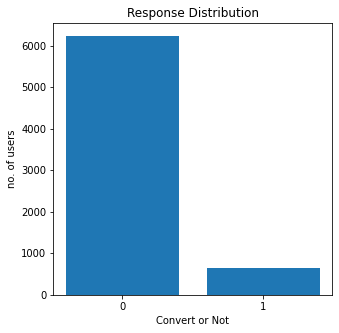

In [12]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [13]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [14]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


## **Creating train and test dataset**

In [15]:
## spliting dataframe into X and y

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [16]:
## creating train and test dataset

X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

**Fixing imbalanced with SMOTE**

In [20]:
sm = SMOTE(random_state=0)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

# **Classification**

## Logistic Regression

In [100]:
print('logistic regression model - SMOTE CLV')
model = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

model_SMOTE_clv = model.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.69      0.65      0.67      4389
           1       0.67      0.71      0.69      4389

    accuracy                           0.68      8778
   macro avg       0.68      0.68      0.68      8778
weighted avg       0.68      0.68      0.68      8778

AUC Score 0.6789701526543632
test set
              precision    recall  f1-score   support

           0       0.94      0.65      0.77      1848
           1       0.18      0.65      0.28       218

    accuracy                           0.65      2066
   macro avg       0.56      0.65      0.53      2066
weighted avg       0.86      0.65      0.72      2066

AUC Score 0.6514456491520711


### **XGBoost**

In [95]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.001,
 n_estimators=100,
 max_depth=2,
 gamma=0.1,
 colsample_bytree=0.1)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv.values, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv.values)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.509045
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.68592
[2]	validation_0-auc:0.699369
[3]	validation_0-auc:0.695204
[4]	validation_0-auc:0.704018
[5]	validation_0-auc:0.702809
[6]	validation_0-auc:0.698845
[7]	validation_0-auc:0.696504
[8]	validation_0-auc:0.697001
[9]	validation_0-auc:0.697683
Stopping. Best iteration:
[4]	validation_0-auc:0.704018

training set
              precision    recall  f1-score   support

           0       0.75      0.60      0.67      4389
           1       0.67      0.80      0.73      4389

    accuracy                           0.70      8778
   macro avg       0.71      0.70      0.70      8778
weighted avg       0.71      0.70      0.70      8778

AUC Score 0.6993620414673046
test set
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      1848
           1       0.18      0.76      0.29       218

    accuracy 

## Random Forests

In [98]:
print('Random Forests - SMOTE CLV')
model = RandomForestClassifier()
predicted_y = []
expected_y = []

model_SMOTE_clv = model.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

Random Forests - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4389
           1       1.00      1.00      1.00      4389

    accuracy                           1.00      8778
   macro avg       1.00      1.00      1.00      8778
weighted avg       1.00      1.00      1.00      8778

AUC Score 1.0
test set
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1848
           1       0.18      0.26      0.21       218

    accuracy                           0.79      2066
   macro avg       0.54      0.56      0.55      2066
weighted avg       0.83      0.79      0.81      2066

AUC Score 0.5587642479844315


## Support Vector machines

In [102]:
print('Support Vector machines - SMOTE CLV')
model = SVC()
predicted_y = []
expected_y = []

model_SMOTE_clv = model.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

Support Vector machines - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.75      0.50      0.60      4389
           1       0.63      0.83      0.72      4389

    accuracy                           0.67      8778
   macro avg       0.69      0.67      0.66      8778
weighted avg       0.69      0.67      0.66      8778

AUC Score 0.6674641148325359
test set
              precision    recall  f1-score   support

           0       0.96      0.49      0.65      1848
           1       0.16      0.84      0.27       218

    accuracy                           0.53      2066
   macro avg       0.56      0.67      0.46      2066
weighted avg       0.88      0.53      0.61      2066

AUC Score 0.667019142936574


## K-Nearest Neighbors

In [101]:
print('K-Nearest Neighbors - SMOTE CLV')
model = KNeighborsClassifier()
predicted_y = []
expected_y = []

model_SMOTE_clv = model.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

K-Nearest Neighbors - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.97      0.80      0.87      4389
           1       0.83      0.97      0.89      4389

    accuracy                           0.89      8778
   macro avg       0.90      0.89      0.88      8778
weighted avg       0.90      0.89      0.88      8778

AUC Score 0.8856231487810435
test set
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1848
           1       0.17      0.46      0.25       218

    accuracy                           0.70      2066
   macro avg       0.54      0.60      0.53      2066
weighted avg       0.84      0.70      0.75      2066

AUC Score 0.5950171770125897


# **Result Dicussion**

After we classify our train and test dataset though those models, the best model is Logistic Regression with XGBoost. AUC Score frome Logistic Regression is quite high and is around AUC score of test dataset. AUC score of train dataset from Random Forests model is 1.0 but AUC score of test data set is belower than then it means this model overfit. SVM and KNN have less AUC score than Logistic Regression
